In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
from preparation import get_logos
logos = get_logos()

# Input pipeline

In [4]:
# filter non-logo images
logos = list(filter(lambda x: x.logo, logos))
len(logos)

2235

In [5]:
files = [x.path for x in logos]
test_idx = [i for i,x in enumerate(logos) if x.test]

def get_class(lg): # for simplicity first annotation is the class
    if not lg.logo: return 'no-logo'
    else: return lg.ann[0].c

name2c = { x.path.name:get_class(x) for x in logos }

name2test = { x.path.name:x.test for x in logos } # is logo?

tfms = get_transforms(max_rotate=180, max_zoom=1.5)

data = (ImageItemList(files)
            .split_by_valid_func(lambda x: name2test[ x.name ])
            .label_from_func(lambda x: name2c[ x.name ])
            .transform(tfms, size=224)
            .databunch(bs=64, num_workers=4)
            .normalize(imagenet_stats)
       )

/home/domas/.conda/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:487: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
chimay_text
  if getattr(ds, 'warn', False): warn(ds.warn)


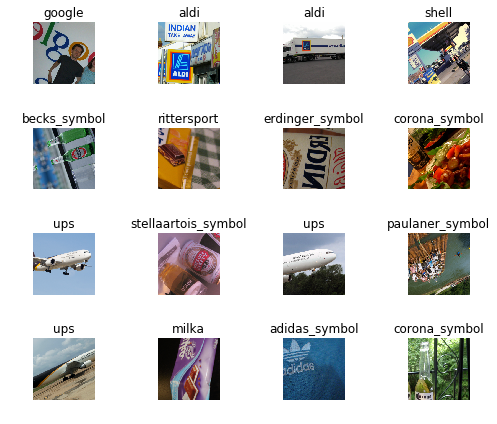

In [6]:
data.show_batch(rows=4, figsize=(7,6))

In [25]:
train_dl = data.dl(ds_type=DatasetType.Train)
for i,(x,y) in enumerate(train_dl):
    print(x.shape, y.shape, y[:10])
    if i > 0: break

torch.Size([64, 3, 224, 224]) torch.Size([64]) tensor([12, 12,  3, 13, 20, 32,  0, 33, 13,  6], device='cuda:0')
torch.Size([64, 3, 224, 224]) torch.Size([64]) tensor([33, 14, 29,  0, 13, 25, 25, 18,  2, 20], device='cuda:0')


# Classification

In [78]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [79]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,2.598084,2.703574,0.682370
2,1.198898,2.147007,0.562455
3,0.717528,1.828943,0.490364
4,0.537561,1.841861,0.498216


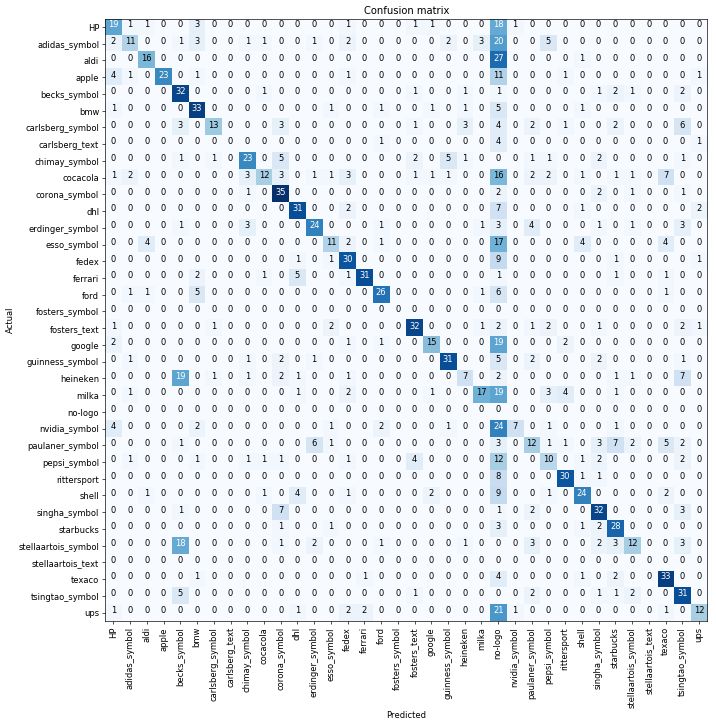

In [80]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

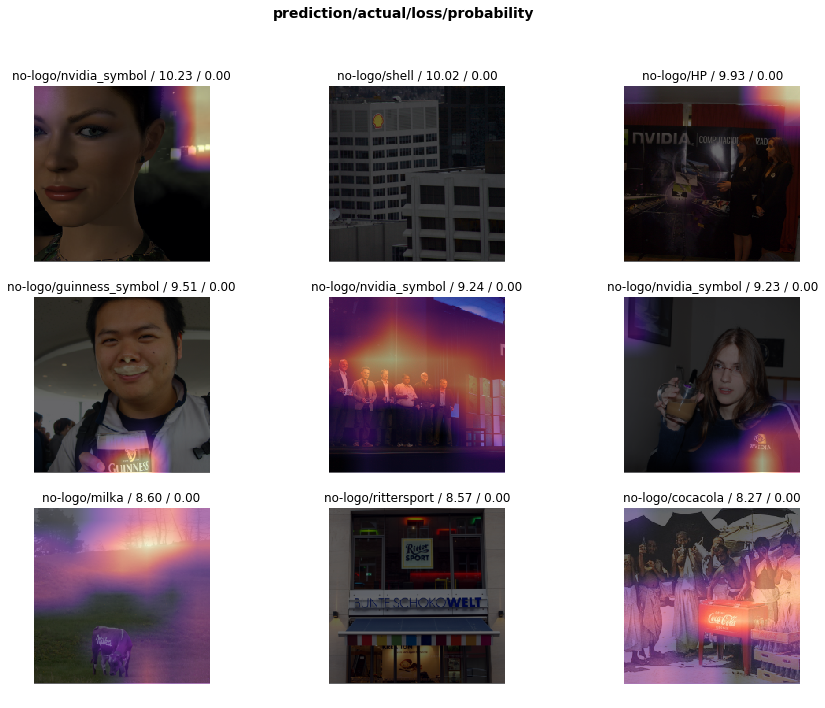

In [81]:
# losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In [51]:
# interp.most_confused()

In [82]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06


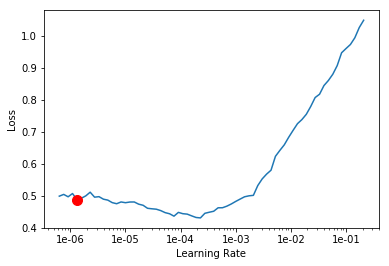

In [83]:
learn.recorder.plot()

In [84]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.470613,1.664223,0.462527
2,0.437541,1.540729,0.436831
3,0.414235,1.543016,0.432548


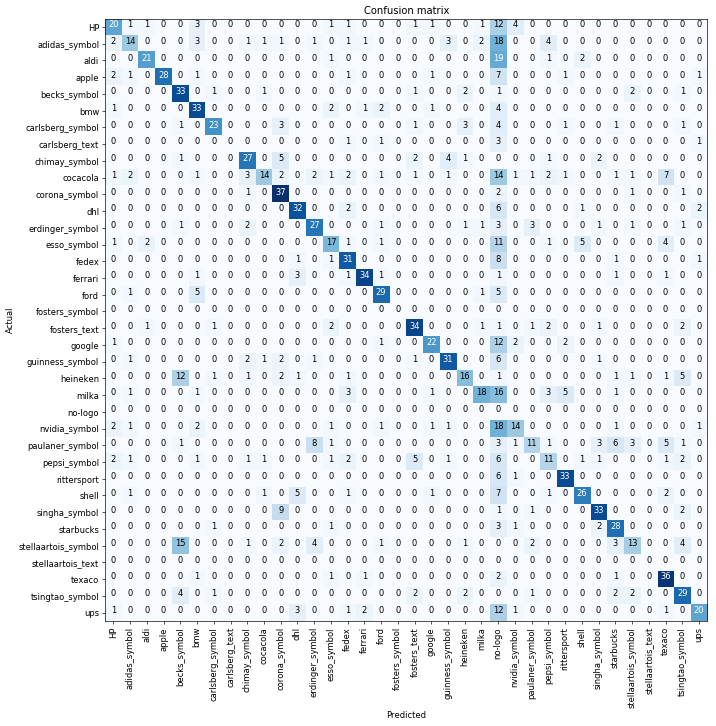

In [85]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


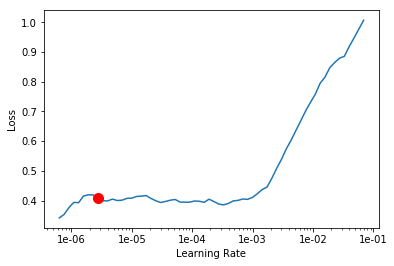

In [86]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

# Custom Head

(needs input pipeline + imports)